In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from statsmodels import regression, stats
##
from util import tools

In [2]:
plt.rcParams['figure.figsize'] = (16, 5)
plt.style.use('seaborn-whitegrid')

### Import BTP yield curve from 2010 to 2020 

In [3]:
path = 'util/datastore/yield_italy_daily_2010_2020.xlsx'
df = tools.load_BTP_curve(path)

In [4]:
df.head()

Tenor,2,3,4,5,6,7,8,9,10,15,20,30
Date,,,,,,,,,,,,
2010-01-04 00:00:00,0.01533,0.02009,0.02431,0.02788,0.03061,0.03389,0.03613,0.03858,0.04108,0.04514,0.04692,0.04800
2010-01-05 00:00:00,0.01510,0.01980,0.02415,0.02785,0.03057,0.03382,0.03614,0.03857,0.04101,0.04522,0.04705,0.04822
2010-01-06 00:00:00,0.01758,0.02239,0.02425,0.02804,0.03081,0.03401,0.03639,0.03878,0.04120,0.04560,0.04747,0.04880
2010-01-07 00:00:00,0.01703,0.02172,0.02374,0.02762,0.03049,0.03371,0.03608,0.03852,0.04094,0.04533,0.04731,0.04877
2010-01-08 00:00:00,0.01670,0.02141,0.02351,0.02738,0.03019,0.03353,0.03594,0.03841,0.04078,0.04523,0.04724,0.04878


In [5]:
# BTP 10y
benchmark = df[10].to_frame()
benchmark_pct = benchmark.pct_change()[1:]
xs = np.arange(len(benchmark_pct))
model = regression.linear_model.OLS(benchmark_pct, sm.add_constant(xs)).fit()
residuals = model.resid

In [6]:
_, pvalue, _, _ = sm.stats.stattools.jarque_bera(residuals)
if pvalue > 0.05:
    print(pvalue)
    print( "Normally distributed")
if pvalue < 0.05:
    print(pvalue)
    print("Reject H0")
    print( "Not Normally distributed")

0.0
Reject H0
Not Normally distributed


### Test for Heteroscedasticity

In [7]:
breusch_pagan_p = smd.het_breuschpagan(residuals, model.model.exog)[1]
print( breusch_pagan_p)
if breusch_pagan_p > 0.05:
    print()
    print( "The relationship is not heteroscedastic.")
if breusch_pagan_p < 0.05:
    print("Reject H0 of no heteroscedasticity")
    print( "The relationship is heteroscedastic.")

1.4224725588654374e-11
Reject H0 of no heteroscedasticity
The relationship is heteroscedastic.


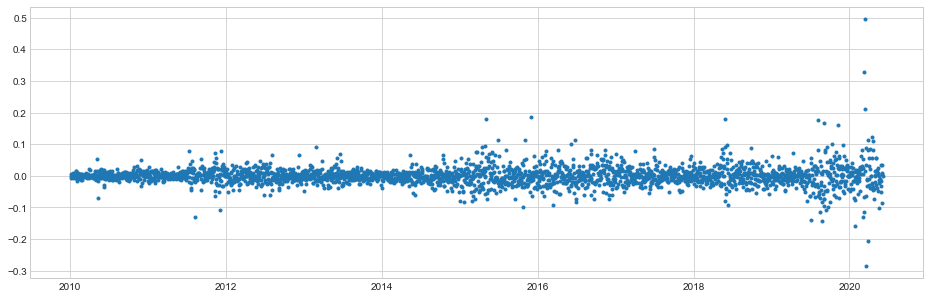

In [9]:
plt.plot(residuals, ".");

### Structural Breaks

In [10]:
benchmark.iloc[520].name

Timestamp('2012-01-02 00:00:00')

In [11]:
reg1 = benchmark.iloc[:520]
reg2 = benchmark.iloc[520:]

In [12]:
xs = np.arange(len(reg2))
residuals = regression.linear_model.OLS(reg2, sm.add_constant(xs)).fit().resid
cusum_p = stats.diagnostic.breaks_cusumolsresid(residuals)[1]
if cusum_p > 0.05:
    print(cusum_p)
    print( "No structrural break")
if cusum_p < 0.05:
    print(cusum_p)
    print("Reject H0 of no structural break")

1.5599240754893622e-82
Reject H0 of no structural break


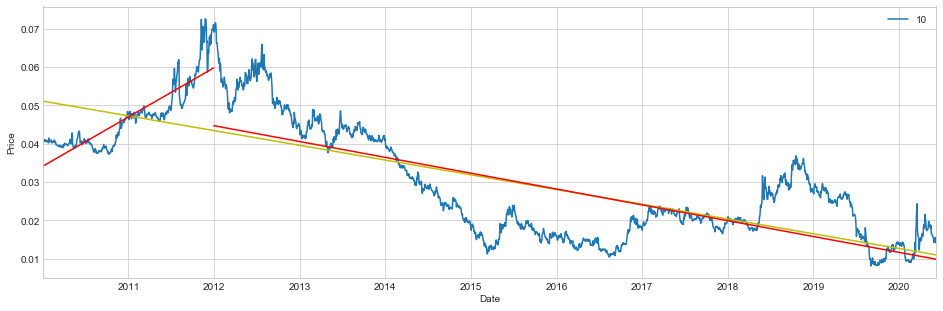

In [13]:
# break strutturale post crisi del debito sovrano 2011
tools.regime_changes(520, benchmark)